In [34]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import torch_geometric
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv
from torch_geometric.data import Data, Dataset, HeteroData
from torch_geometric.loader import DataLoader
#from torch_geometric.graphgym import params_count
import torch_geometric.utils as Utils
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import mplhep as hep

plt.style.use(hep.style.CMS)
torch_geometric.__version__

'2.0.1'

In [35]:
print("===== Loading Files ...")
trainData = "./dataProcessed/dataTraining.pt"
layData = './dataProcessed/dataTrainingLay.pt'
valData = "./dataProcessed/dataVal.pt"
testData = "./dataProcessed/dataTest.pt"
trainDatasetLay = torch.load(layData)
trainDataset = torch.load(trainData)
valDataset = torch.load(valData)
testDataset = torch.load(testData)
print("===== Loaded! ")

===== Loading Files ...
===== Loaded! 


In [36]:
def focal_loss(bce_loss, targets, gamma, alpha):
    """Binary focal loss, mean.

    Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
    improvements for alpha.
    :param bce_loss: Binary Cross Entropy loss, a torch tensor.
    :param targets: a torch tensor containing the ground truth, 0s and 1s.
    :param gamma: focal loss power parameter, a float scalar.
    :param alpha: weight of the class indicated by 1, a float scalar.
    """
    p_t = torch.exp(-bce_loss)
    alpha_tensor = (1 - alpha) + targets * (2 * alpha - 1)  # alpha if target = 1 and 1 - alpha if target = 0
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss
    return f_loss.mean()

In [37]:
class Net(nn.Module):
    def __init__(self,num_filters=4, out_features=2):
        super().__init__()
        self.conv1 = nn.Conv1d(1, num_filters, 3, stride=1, dilation=1)
        self.conv2 = nn.Conv1d(num_filters, 2*out_features, 3, stride = 3)
        self.conv3 = nn.Conv1d(2*out_features, 2*out_features, 3, stride = 3)
        self.conv4 = nn.Conv1d(2*out_features, 2*2*out_features, 3, stride = 3)
        self.pool = nn.MaxPool1d(1)
#         self.pool = nn.AvgPool1d(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1]))
        return x


net = Net()
class GraphNet(nn.Module):
    def __init__(self, input_dim = 12, hidden_dim = 128, output_dim = 1, aggr = 'add', niters = 4):
        super(GraphNet, self).__init__()
        self.featureExtractor = Net()
        
        # transform to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
#             nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2*hidden_dim, hidden_dim),
#             nn.ReLU()
        )
        
        # to compute messages
        convnetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # EdgeConv
        self.graphconv = EdgeConv(nn=convnetwork, aggr=aggr)
        
        # edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
        self.niters = niters
    
    def forward(self, data, device = "cuda"):
        X = data.x
        en_lay = data.en_hgcal_layers
#         print(en_lay.shape)
        en_lay = en_lay.cpu()
#         print(en_lay.shape)
        en_lay_in = torch.reshape(torch.from_numpy(np.float32(en_lay)), (en_lay.shape[0],1,en_lay.shape[1]))
#         print(en_lay_in.shape)
        
        if(device == 'cuda'):
            en_lay_in = en_lay_in.cuda()
        
#         features = self.featureExtractor(en_lay_in)
        #print(f"initial X size {X.size()}")
#         X = torch.cat([X, features], dim = -1)
        H = self.inputnetwork(X)
        #print(f"size after inputnet {H.size()}")
        for i in range(self.niters):
            (prepared_edges, _) = Utils.add_self_loops(data.edge_index)
            H = self.graphconv(H, Utils.to_undirected(prepared_edges))
            #print(f"size of H after {i}th iter {H.size()}")
            
        src, dst = data.edge_index
        #print(f"src size {H[src].size()} dest size {H[dst].size()}")
        #print(f"torch cat {torch.cat([H[src], H[dst]], dim=-1).size()}")
        #print(f"GraphNet returns {self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1).size()}")
        #print(f"score size {(H[src] * H[dst]).sum(dim=-1)}")
        #return (H[src] * H[dst]).sum(dim=-1)
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [38]:
# Imbalance in training
train_edges_total = 0
train_edges_true = 0
train_edges_false = 0

for tr_data in trainDataset:
    train_edges_total += len(tr_data.edge_index[0])
    for label in tr_data.edge_label:
        if label.numpy() == 0:
            train_edges_false += 1
        elif label.numpy() == 1:
            train_edges_true += 1
        
print(f"Total edges in training : {train_edges_total}")
print(f"True edges : {train_edges_true}")
print(f"False edges : {train_edges_false}")

# # edges in test dataset
# test_edges_total = 0
# test_edges_true = 0
# test_edges_false = 0
# for test_data in testDataset:
#     test_edges_total += len(test_data.edge_index[0])
#     for label in test_data.edge_label:
#         if label.numpy() == 0:
#             test_edges_false += 1
#         elif label.numpy() == 1:
#             test_edges_true += 1
            
# print(f"\nTotal edges in test : {test_edges_total}")
# print(f"True edges : {test_edges_true} - {test_edges_true/test_edges_total*100}%")
# print(f"False edges : {test_edges_false} - {test_edges_false/test_edges_total*100}%")

Total edges in training : 10639134
True edges : 6527329
False edges : 4111805


In [39]:
# Calculate weights
w_false = train_edges_total/(2*train_edges_false)
w_true = train_edges_total/(2*train_edges_true)
print(f"Weights True, False edges : {w_true}, {w_false}")

Weights True, False edges : 0.8149684197012285, 1.29373036902285


In [40]:
# Training
epochs = 100
batch_size = 32
PATH = "model/trackster_graphconv_noLC"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphNet().to(device)
#data = data_list.to(device)
trainLoader = DataLoader(trainDataset, batch_size=batch_size)
valLoader = DataLoader(valDataset, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=1e-4, threshold_mode='abs')

train_loss_history = []
val_loss_history = []
model.train()
best_loss = 1e6
focal_loss_param = 0.4
for epoch in range(epochs):
    batchloss = []
    for sample in trainLoader:
        optimizer.zero_grad()
        sample.to(device)
        out = model(sample)
#         weight = [w_true if l > 0.9 else w_false for l in sample.edge_label] # weigh edges
#         loss = F.binary_cross_entropy(out, sample.edge_label, weight=torch.tensor(weight))
        bce_loss = F.binary_cross_entropy(out, sample.edge_label)
        loss = focal_loss(bce_loss, sample.edge_label, 2, focal_loss_param)
#         print(f"out {out}")
#         print(f"label {sample.edge_label}")
#         print(f"loss {loss}")
        batchloss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for param_group in optimizer.param_groups:
        print(f"lr: {param_group['lr']}")
    batch_loss_mean = np.mean(batchloss)
    train_loss_history.append(batch_loss_mean)
    if(batch_loss_mean < best_loss):
        # Save model so as not to repeat the training
        torch.save(model.state_dict(), PATH +".pt")
    with torch.set_grad_enabled( False ):
        batchloss = []
        for sample in valLoader:
            sample.to(device)
            out = model(sample)
            #val_loss = F.binary_cross_entropy_with_logits(out, sample.edge_label)
            val_bce = F.binary_cross_entropy(out, sample.edge_label)
            val_loss = focal_loss(val_bce, sample.edge_label, 2, focal_loss_param)
            batchloss.append(val_loss.item())
            
    val_loss_history.append(np.mean(batchloss))
    scheduler.step(val_loss_history[-1])
    print(f"epoch {epoch} - train loss {train_loss_history[-1]:.4f} - val loss {val_loss_history[-1]:.4f}")
    
# Save model so as not to repeat the training

torch.save(model.state_dict(), PATH +"_final.pt")

lr: 0.0001
epoch 0 - train loss 0.1228 - val loss 0.0744
lr: 0.0001
epoch 1 - train loss 0.0730 - val loss 0.0715
lr: 0.0001
epoch 2 - train loss 0.0703 - val loss 0.0685
lr: 0.0001
epoch 3 - train loss 0.0670 - val loss 0.0640
lr: 0.0001
epoch 4 - train loss 0.0630 - val loss 0.0613
lr: 0.0001
epoch 5 - train loss 0.0604 - val loss 0.0592
lr: 0.0001
epoch 6 - train loss 0.0585 - val loss 0.0579
lr: 0.0001
epoch 7 - train loss 0.0566 - val loss 0.0564
lr: 0.0001
epoch 8 - train loss 0.0554 - val loss 0.0549
lr: 0.0001
epoch 9 - train loss 0.0545 - val loss 0.0541
lr: 0.0001
epoch 10 - train loss 0.0538 - val loss 0.0535
lr: 0.0001
epoch 11 - train loss 0.0533 - val loss 0.0530
lr: 0.0001
epoch 12 - train loss 0.0529 - val loss 0.0528
lr: 0.0001
epoch 13 - train loss 0.0526 - val loss 0.0525
lr: 0.0001
epoch 14 - train loss 0.0523 - val loss 0.0525
lr: 0.0001
epoch 15 - train loss 0.0521 - val loss 0.0521
lr: 0.0001
epoch 16 - train loss 0.0520 - val loss 0.0518
lr: 0.0001
epoch 17 - tr

In [ ]:
xaxis = range(1, epochs+1)
plt.plot(xaxis, train_loss_history, label='train')
plt.plot(xaxis, val_loss_history, label='val')
plt.ylabel("Loss")
plt.xlabel("Epochs")
#plt.xticks(range(epochs), range(1, epochs+1))
plt.legend()

In [ ]:
model

In [ ]:
model_test = model

In [16]:
torch.load(PATH).keys()

odict_keys(['featureExtractor.conv1.weight', 'featureExtractor.conv1.bias', 'featureExtractor.conv2.weight', 'featureExtractor.conv2.bias', 'featureExtractor.conv3.weight', 'featureExtractor.conv3.bias', 'featureExtractor.conv4.weight', 'featureExtractor.conv4.bias', 'inputnetwork.0.weight', 'inputnetwork.0.bias', 'inputnetwork.1.weight', 'inputnetwork.1.bias', 'inputnetwork.1.running_mean', 'inputnetwork.1.running_var', 'inputnetwork.1.num_batches_tracked', 'inputnetwork.3.weight', 'inputnetwork.3.bias', 'graphconv.nn.0.weight', 'graphconv.nn.0.bias', 'graphconv.nn.3.weight', 'graphconv.nn.3.bias', 'edgenetwork.0.weight', 'edgenetwork.0.bias', 'edgenetwork.3.weight', 'edgenetwork.3.bias', 'edgenetwork.6.weight', 'edgenetwork.6.bias'])

In [17]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test = GraphNet()
model_test.load_state_dict(torch.load(PATH))
model_test.eval()
model_test.to(device)

GraphNet(
  (featureExtractor): Net(
    (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
    (conv2): Conv1d(4, 4, kernel_size=(3,), stride=(3,))
    (conv3): Conv1d(4, 4, kernel_size=(3,), stride=(3,))
    (conv4): Conv1d(4, 8, kernel_size=(3,), stride=(3,))
    (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (inputnetwork): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  )
  (graphconv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
  ))
  (edgenetwork): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dr

In [18]:
sum(p.numel() for p in model.parameters())

167905

In [19]:
len(testDataset[0][-1][0])

51

In [20]:
def normalize_and_get_data(data_list, ev):
    data_list_ev = data_list[ev]
    x_np = data_list_ev[0]
    x_coord_slice = x_np[:, [0,1,2]]
    x_rest_slice = x_np[:, [9,10,11]]
    x_en_lay_ev = data_list_ev[-1]
    mean = []
    std = []
    scaler=StandardScaler()
    scaler.fit(x_coord_slice)
    x_coord_norm = scaler.transform(x_coord_slice)
    mean.append(scaler.mean_)
    std.append(scaler.scale_)
    
    mean.append(np.zeros(6)) # for the unnormalized features
    std.append(np.ones(6))
    
    scaler.fit(x_rest_slice)
    x_rest_norm = scaler.transform(x_rest_slice)
    mean.append(scaler.mean_)
    std.append(scaler.scale_)
    
    mean = np.concatenate(mean, axis=-1)
    std = np.concatenate(std, axis=-1)
    
    x_ev = torch.from_numpy(np.concatenate((x_coord_norm, x_np[:,[3,4,5,6,7,8]], x_rest_norm), axis=1))
    edge_label = torch.from_numpy(data_list_ev[1])
    edge_index = torch.from_numpy(data_list_ev[2])
    data = Data(x=x_ev, num_nodes=torch.tensor(x_ev.shape[0]), edge_index=edge_index, edge_label=edge_label, en_hgcal_layers = x_en_lay_ev)
    
    return data, mean, std

testData = []
for ev in range(len(testDataset)):
    data, mean, std = normalize_and_get_data(testDataset, ev)
    testData.append(data)

In [21]:
#testDataset = torch.load("/eos/user/w/wredjeb/SWAN_projects/GraphSC/HackathonLinking/dataProcessed/dataTest.pt")
classification_threshold = 0.7
def getAccuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > classification_threshold
    return (y_true == y_prob).sum().item() / y_true.size(0)

testLoader = DataLoader(testData, batch_size=batch_size)
print("loaded")

predictions = []
truth = []
accuracies = []

for sample in testLoader:
    sample.to(device)
    out = model_test(sample)
    acc = getAccuracy(sample.edge_label, out)
    accuracies.append(acc)
    y_test = out > classification_threshold
    predictions.append(y_test.cpu().numpy())
    truth.append(sample.edge_label.cpu().numpy())
    
cf_matrix = confusion_matrix(np.concatenate(truth), np.concatenate(predictions))
#cf_matrix = confusion_matrix(sample.edge_label.detach().numpy(), y_test.detach().numpy())
print(f"Accuracy in test data {np.mean(accuracies)*100:.4f} %")
print(f"Confusion matrix {cf_matrix}")

loaded
Accuracy in test data 61.4240 %
Confusion matrix [[441057  68675]
 [441040 367754]]


In [22]:
model.cuda()

GraphNet(
  (featureExtractor): Net(
    (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
    (conv2): Conv1d(4, 4, kernel_size=(3,), stride=(3,))
    (conv3): Conv1d(4, 4, kernel_size=(3,), stride=(3,))
    (conv4): Conv1d(4, 8, kernel_size=(3,), stride=(3,))
    (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (inputnetwork): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  )
  (graphconv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
  ))
  (edgenetwork): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dr

In [23]:
# trying to accumulate connected tracksters in superclusters
eventLoader = DataLoader(testData, batch_size=1)
events=0
edges_event = []
preds_event = []
nodes_event = []
events = 0
for sample in eventLoader:
    events+=1
    sample.to("cpu")
    model.to("cpu")
    outGraph = model(sample, "cpu")
    edges_event.append(sample.edge_index)
    preds_event.append(outGraph)
    nodes_event.append(len(sample.x))
    #print(len(sample.edge_index[0]))
    #print(len(outGraph))
    if events > 10:
        break

In [24]:
tn, fp, fn, tp = cf_matrix.ravel()
tot = tn+fp+fn+tp
# normalized to total edges in test dataset
print(f"{cf_matrix/tot}\n")
print(f"Accuracy : {(tp+tn)/tot*100:.4f}%")
print(f"Precision : {tp/(tp+fp)*100:.4f}")
print(f"Recall : {tp/(tp+fn)*100:.4f}% -> positive edges correctly classified")
print(f"Correctly classifying {tn/(tn+fp)*100:.4f}% of all negative edges")

[[0.33450762 0.05208468]
 [0.33449473 0.27891297]]

Accuracy : 61.3421%
Precision : 84.2643
Recall : 45.4694% -> positive edges correctly classified
Correctly classifying 86.5272% of all negative edges


TN: 0.33450762442302995, FP: 0.05208467637346552, FN: 0.33449473123776097, TP: 0.27891296796574355


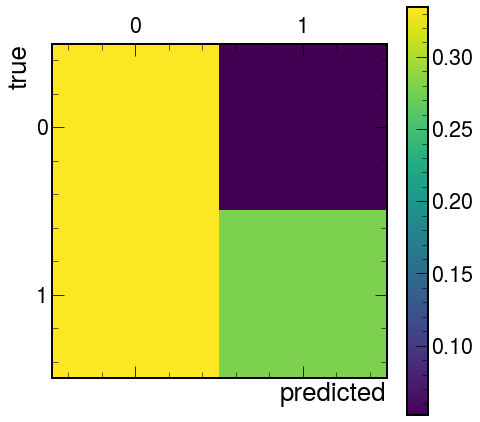

In [25]:
print(f"TN: {tn/tot}, FP: {fp/tot}, FN: {fn/tot}, TP: {tp/tot}")
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.set_xlabel("predicted")
px.set_ylabel("true")
cax = px.matshow(cf_matrix/(tn+fp+fn+tp))
fig.colorbar(cax)